# **Introduction**

   The goal of this notebook is to explain and implement Gradient Descent for Softmax Regression (without using Scikit-Learn).

   Logistic regression is using a probability between 0 and 1 (based on a sigmoid function) to identify which of two categories a probability falls into (eg. this is the number 5 or is not the number 5). 
   
   Softmax regression is the same thing as logistic regression, but it uses more than two possible outcomes (or output classes), outputs a probability between 0 and 1 for each outcome, and then based on which of those outcomes has the highest probability (eg. "I am 80% sure that I am looking at 4. I am going to say it is a 4.") . This entails that the classes that we are classifying be exclusive (eg. the single digit number we are identifying is not both an 8 and a 0, it is one or the other).

We are going to work on the MNIST Data set as the classes are exclusive (they are digits 0-9 and they are only one digit at a time, not 5 and 3 both for example).

**Imports**

In [1]:
import plotly as py
#import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

As you can see in the shape of our data, X, there are 70,000 example handwritten digits, and each one is made up of 784 pixels (a 28 x 28 box). 

The value for each pixel, as seen below for the first example, can range from 0 (white) to 255 (black) in grayscale. 

In [3]:
X[0].reshape(28,28)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

To prepare our data, I'm starting by adding a bias term of 1 to each digit. This bias term is similar to a y-intercept (b) in the equation for a line $y = mx + b$. It allows for predictions to be adjusted without regard to variables.

To keep the calculations from becoming too large and not being able to compute, I divide all X values by 255 to start, as 255 is the maximum possible value. This is called normalizing.

In [4]:
#adding a bias term to each digit
X_with_bias = np.c_[np.ones([len(X), 1]), X]
#normalizing
X_with_bias = X_with_bias/255

In [5]:
len(X)

70000

As the labels come in the form of strings, here I create a function to convert them to numbers based on their index in a list of unique values.

In [6]:
def categorical_to_num(y):
    nums = np.zeros(y.size)
    for i in range(len(np.unique(y))):
        nums[np.where(y==np.unique(y)[i])] = i
    return nums.astype(int)

Here we create a function to convert the labels in their number form to a one-hot encoding (puts a one in the column of a row the same length as the number of possible options). This will become needed later when calculating loss and gradients.

In [7]:
def to_one_hot(y):
    shape = (y.size, int(np.max(y) + 1))
    rows = np.arange(y.size)
    one_hot = np.zeros(shape)
    one_hot[rows, y] = 1.
    return one_hot

We will split up the 70,000 example hand-written digits below into an 80%/20% split between training and test data.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_with_bias, y, train_size = 0.8, random_state = 42)
print("X_train size:", X_train.shape, '\n',
    "X_val size:", X_val.shape, '\n',
    "y_train size:", y_train.shape, '\n',
    "y_val size:", y_val.shape, '\n')

X_train size: (56000, 785) 
 X_val size: (14000, 785) 
 y_train size: (56000,) 
 y_val size: (14000,) 



In [9]:
#converting y validation set to one hot
nums = categorical_to_num(y_val)
y_val_one_hot = to_one_hot(nums)
y_val_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [10]:
#converting y training set to one hot
nums = categorical_to_num(y_train)
y_train_one_hot = to_one_hot(nums)
y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Here are the equations that we will need for building out the softmax regressor:

# Softmax Score

This equation is used for scoring probabilities. That means combining our prior or initial thought of the weight or importance that each pixel of a handwritten digit make it part of a certain class, with a new handwritten digit ("based on what I think up front how much do I think that this new digit is a 4?").

$s_k$ is the score (logits) for class $k$. 

$\mathbf{x}$ is the batch of handwritten digits you are supplying the model.

$\mathbf{\theta}$ (theta) is the weight for the class ${k}$ that we are working with.

The $^T$ next to $\mathbf{\theta}$ shows that we are going to transpose it before taking the dot product of it and our handwritten digits $\mathbf{x}$.



$$s_k(\mathbf{x}) = (\mathbf{\theta}^{(k)})^T\mathbf{x}$$

As this is the dot product of $\mathbf{\theta}$ and $\mathbf{x}$, we have to make sure that our dimensions match (the last dimension of the first matrix is the same as the first dimension of the second matrix). $\mathbf{x}$ will be in the shape of (m, n_inputs) and $\mathbf{\theta}$ will be in the shape of (n_inputs, n_outputs).

Notice how we implement it:

In [11]:
def SoftmaxScore(x, theta):
    score = x@theta
    return score

# Softmax Function

In [12]:
x=np.linspace(-10, 10, 100)
z=1/(1+np.exp(-x))
px.line(x=x, y=z,
       labels={'x':'X', 'y':'Sigmoid(X)'}, title='Sigmoid Function')

The $\mathbf{\sigma}$ function puts the scores we just got and puts them on a limited range of probabilities (between 0 and 1). This results in an s shaped graph (as shown above), that gets infinitely close to 0 on the left side, and infinitely close to 1 on the right side (being able to visualize these probabilities helps with intuition).

$\hat{p}$ Shows that we are aiming to define probabilities.

The $i$ in $\mathbf{\sigma} {(\overrightarrow z)}_i$ lets you know that we are doing this sigmoid function for just one example (instance) of a handwritten digit.

$\overrightarrow z$ are the logits (the dot product of the weights $\mathbf{\theta}$ and instances $\mathbf{x}$).

$e^{zi}$ Is Euler's constant to the power of the score $z$ we just found for an individual class $i$ (one possible digit the instance could be). $e^{zj}$ Is the same idea, but we are taking the sum of all the possible digits it could be (0-9) so we use a different character $j$ to represent it.

This is called taking the exponent of a number. In this case that number is the logit we computed in the softmax score function.

The reason we use Euler's constant here is because it allows us to focus on the exponent's value itself (because in exponential equations the derivative of Euler's constant to any power is itself).

$\sum_{j=1}^{K}$ is the sum of the exponent of each logit ($e$ to the power of each logit over all classes for all handwritten digits.

This is referred to as normalizing the exponent of the score.

$$\hat{p} = \mathbf{\sigma} {(\overrightarrow z)}_i = \frac{e^{zi}}{{\sum_{j=1}^{K} e^{zj}}}$$

Here's how we will implement it (broken up so that it's not as computationally expensive):

In [13]:
def SoftmaxFunction(score):
    exps = np.exp(score)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

# Softmax Regression Classifier Prediction

This function states that the class with the highest probability (the digit that it is most likely to be) will be chosen as the prediction for a given handwritten digit.

$\hat{y}$ (or y hat) represents our final prediction of what handwritten an instance is.

$$\hat{y} = \underset{k}{\operatorname{argmax}} \mathbf{\sigma}(\mathbf{s}(\mathbf{x}))_k = \underset{k}{\operatorname{argmax}}s_k(\mathbf{x}) = \underset{k}{\operatorname{argmax}} ((\mathbf{\theta}^{(k)})^T\mathbf{x}) $$

We will implement it like this:

In [14]:
def Prediction(p_hat):
    y_hat = np.argmax(p_hat, axis = 1)
    return y_hat

# Cross Entropy Cost Function

This cost function identifies how wrong a prediction was using the natural log of its probability, and multiplies by 1 (if that class was the correct one), then all of these distances get averaged together for a collective distance from the correct predictions.

${J}(\mathbf{\Theta})$ represents the cost over the weight vector of the entire batch

$m$ is the number of instances in the batch

$i$ is one such instance

$k$ is one possible class

$K$ is a set of all of the classes

$log$ is the natural log (again the base is $e$ because it simplifies our math, because the slope of the graph is constant)

$y_k^{(i)}$ is either a 0 (if the handwritten digit was not of that class) or 1 (if it was part of that class)

Bonus: Logarithms are useful in this situation because they "undo" exponential equations (because they are the inverse). So because we got $\hat{p}$ using normalizing exponentials, taking the natural log helps us to correlate gradients more closely with larger mistakes in prediction.


$${J}(\mathbf{\Theta}) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}y_k^{(i)} log(\hat{p}_k^i)$$

Here's how we can implement it:

In [15]:
def xentropyloss(y, p_hat):
    epsilon = 1e-6
    #we will add epsilon (really small number) to p_hat 
    #before taking the log to avoid p_hat being 0
    loss = -np.mean(np.sum(np.log(p_hat + epsilon) * y,axis=1))
    return loss

# Cross Entropy Gradient Vector

This is the derivative of the cost function that we just defined above. This will allow us to perform gradient descent in order to optimize the cost function (lower the amount of error). 

$\mathbf{\nabla}$ (nabla) Is the math symbol for a gradient.

$\sum_{i=1}^{m}$ Takes the sum of the difference between the ground truth and the probability for all instances in the batch.

Multiplying by $\frac{1}{m}$ will give us the average cost over the entire batch.

By multiplying by $\mathbf{x}$ you effect each pixel represented in the handwritten digit.

$$\mathbf{\nabla}_{\theta_{k}} J(\mathbf{\Theta}) = \frac{1}{m} \sum_{i=1}^{m}(\hat{p}_k^{(i)}-{y}_k^{(i)})\mathbf{x}^{(i)} $$

Here's how we can implement it (again, broken up so as to not be too computationally expensive):

In [16]:
def GradientStep(p_hat, theta, y, x, lr, m):
    cost = p_hat - y
    gradients = 1/m * x.T.dot(cost)
    theta = theta - lr * gradients
    return theta
    

# Putting It All Together

Now that we have all of our equations in place, we will put it all together!

In [17]:
lr = 0.5
n_inputs = X_train.shape[1]
m = 10000 #batch size
n_outputs = len(np.unique(y))
epochs = 5001
np.random.seed(2042)
theta = np.random.randn(n_inputs, n_outputs)
charts = {}

Here's a visualization of the weight vector used of the digit 7. As you can see it begins as random noise.

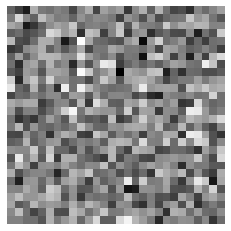

In [18]:
image_theta = theta[:,7][:784].reshape(28, 28)
image_theta = (image_theta/image_theta.max()) * 255

plt.imshow(image_theta, cmap = 'binary')
plt.axis('off')
plt.show()

In [19]:
for epoch in range(epochs):
    score = SoftmaxScore(X_train[:m], theta)
    p_hat = SoftmaxFunction(score)
    if epoch % 50 == 0:
        loss = xentropyloss(y_train_one_hot[:m], p_hat)
        print(epoch, ':', loss )
        charts[str(epoch)] = loss
    theta = GradientStep(p_hat, theta, y_train_one_hot[:m], X_train[:m], lr, m)

0 : 10.878938871226115
50 : 1.9716483973871328
100 : 1.3331139084987558
150 : 1.0921356364688097
200 : 0.9561829112459547
250 : 0.8655266812842394
300 : 0.7994987429441435
350 : 0.7484524417404076
400 : 0.7073000377791592
450 : 0.6730834236670674
500 : 0.6439486972988038
550 : 0.6186753419394124
600 : 0.5964306634737346
650 : 0.57662648312924
700 : 0.5588303756713245
750 : 0.5427129825843854
800 : 0.5280173664657781
850 : 0.51453982741138
900 : 0.5021165788071363
950 : 0.490614049511929
1000 : 0.4799218097438682
1050 : 0.4699474208136481
1100 : 0.46061267193175454
1150 : 0.45185081995486237
1200 : 0.4436045440932125
1250 : 0.4358243822434774
1300 : 0.4284674740365358
1350 : 0.4214965058672738
1400 : 0.41487881160700835
1450 : 0.4085856137601892
1500 : 0.4025913981204155
1550 : 0.3968734117394451
1600 : 0.39141126696926876
1650 : 0.38618662839848994
1700 : 0.38118295834450083
1750 : 0.37638530101471895
1800 : 0.3717800929393422
1850 : 0.36735499413705963
1900 : 0.363098738544139
1950 : 

Here's a plot of how training optimizes the loss function.

In [20]:
charts.pop('0')
fig = px.line(charts.values(), title='Training Loss', labels={'x':'Epoch', 'y':'Loss'})
fig.update_layout(xaxis_title='Epoch (Each One is 50)', yaxis_title='Loss')

In [21]:
score = SoftmaxScore(X_val, theta)
p_hat = SoftmaxFunction(score)
pred = Prediction(p_hat)

accuracy = np.mean(pred == categorical_to_num(y_val))
accuracy

0.8795714285714286

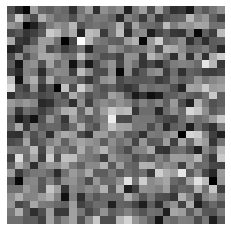

In [22]:
image_theta = theta[:,7][:784].reshape(28, 28)
image_theta = (image_theta/image_theta.max()) * 255

plt.imshow(image_theta, cmap = 'binary')
plt.axis('off')
plt.show()

It's still pretty fuzzy, but you can make out the figure of a 7 slightly.

In [23]:
image_theta.max()

255.0

For the sake of comparing to a baseline. Notice that the score that is achievable with the pre-built Scikit-Learn softmax regressor is very close to our accuracy score.

In [24]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10, max_iter = 5001)
softmax_reg.fit(X_train[:10000], y_train[:10000])
val_predictions = softmax_reg.predict(X_val)
val_score = accuracy_score(y_val, val_predictions)
val_score

0.8814285714285715